In [ ]:
!pip install tensorflow
!pip install tensorflow_text
!pip install wordcloud

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow import keras
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from pylab import rcParams
import numpy as np
from sklearn.model_selection import train_test_split

use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data")
# !ls

Mounted at /content/gdrive


In [ ]:
# df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data/covid_16k.csv",encoding='utf-8')
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data/covid_trainx3.csv")

In [ ]:
df.head()

In [ ]:
df["text"] = df["text"]
df["legit"] = df["legit"]
df = df[["text", "legit"]]

In [ ]:
df.legit.value_counts()

In [ ]:
fake_tweets = df[df.legit == 0]
real_tweets = df[df.legit == 1]
# print(real_tweets.shape, fake_tweets.shape)

In [ ]:
fake_df = fake_tweets
real_df = real_tweets

In [ ]:
tweet_df = pd.concat([real_df,fake_df]).reset_index(drop=True)
# tweet_df.shape

In [ ]:
tweet_df.head()
# 1 = real
# 0 = fake

In [ ]:
real_tweets_text = " ".join(real_tweets.text.to_numpy().tolist())
fake_tweets_text = " ".join(fake_tweets.text.to_numpy().tolist())

real_tweets_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(real_tweets_text)
fake_tweets_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(fake_tweets_text)

In [ ]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

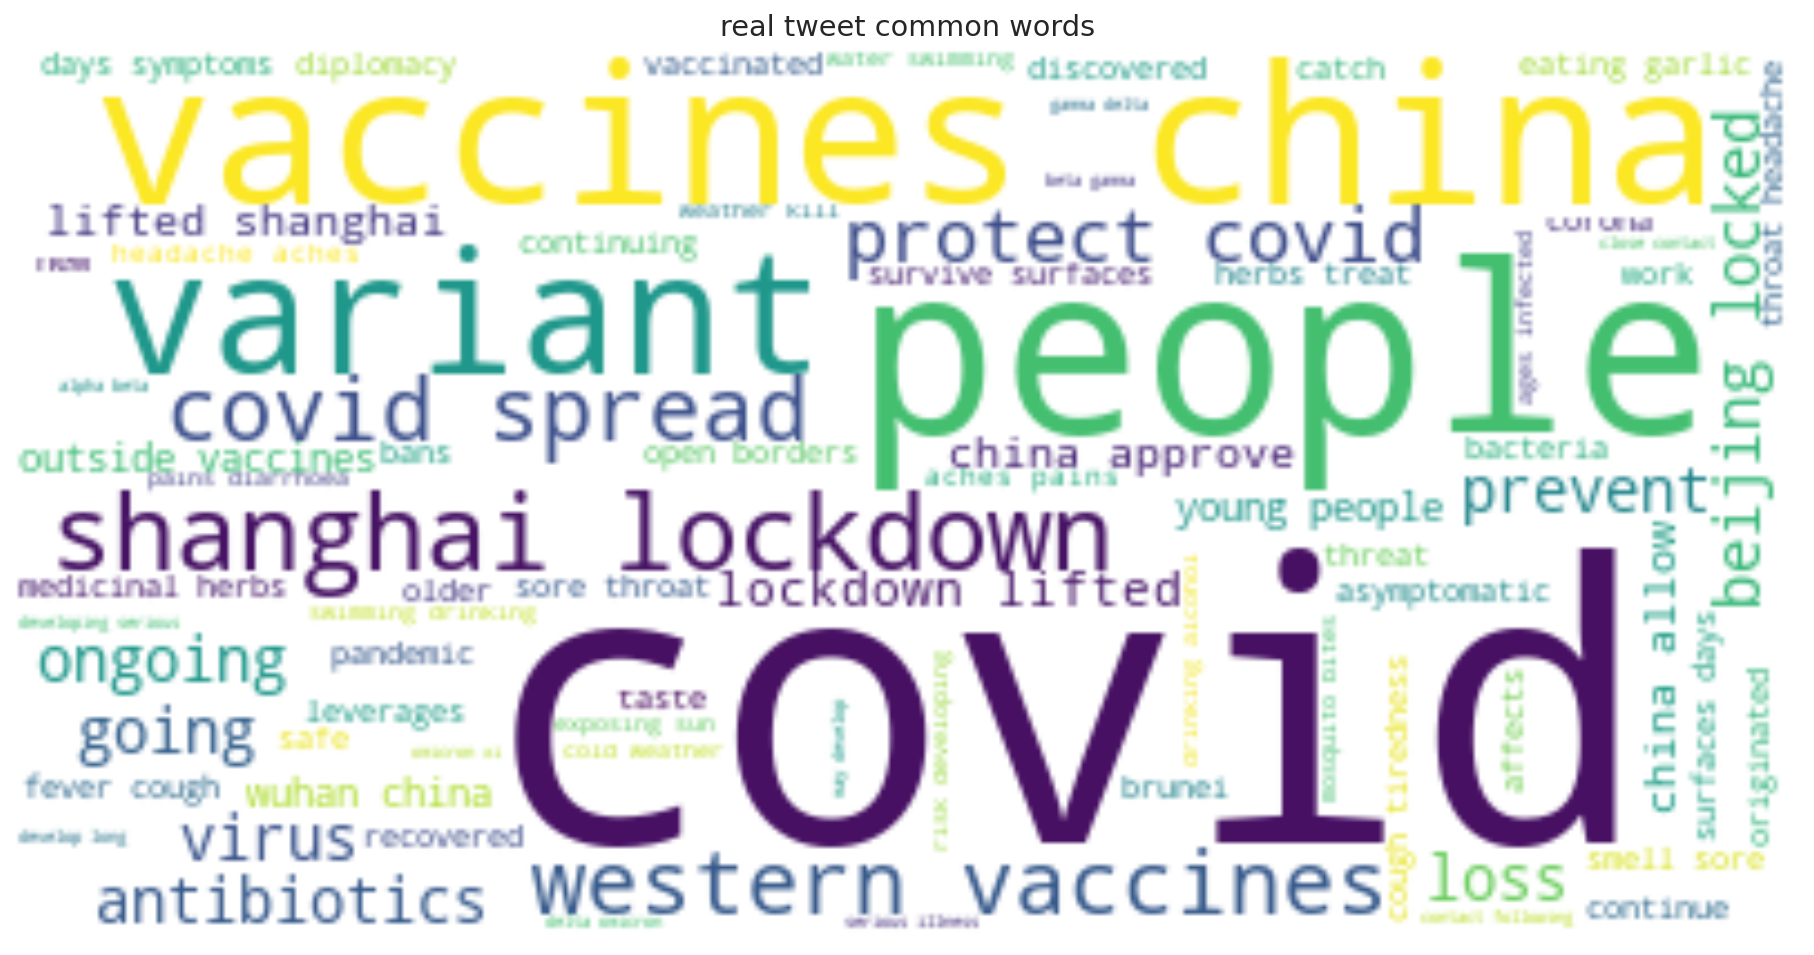

In [ ]:
show_word_cloud(real_tweets_cloud, "real tweet common words")

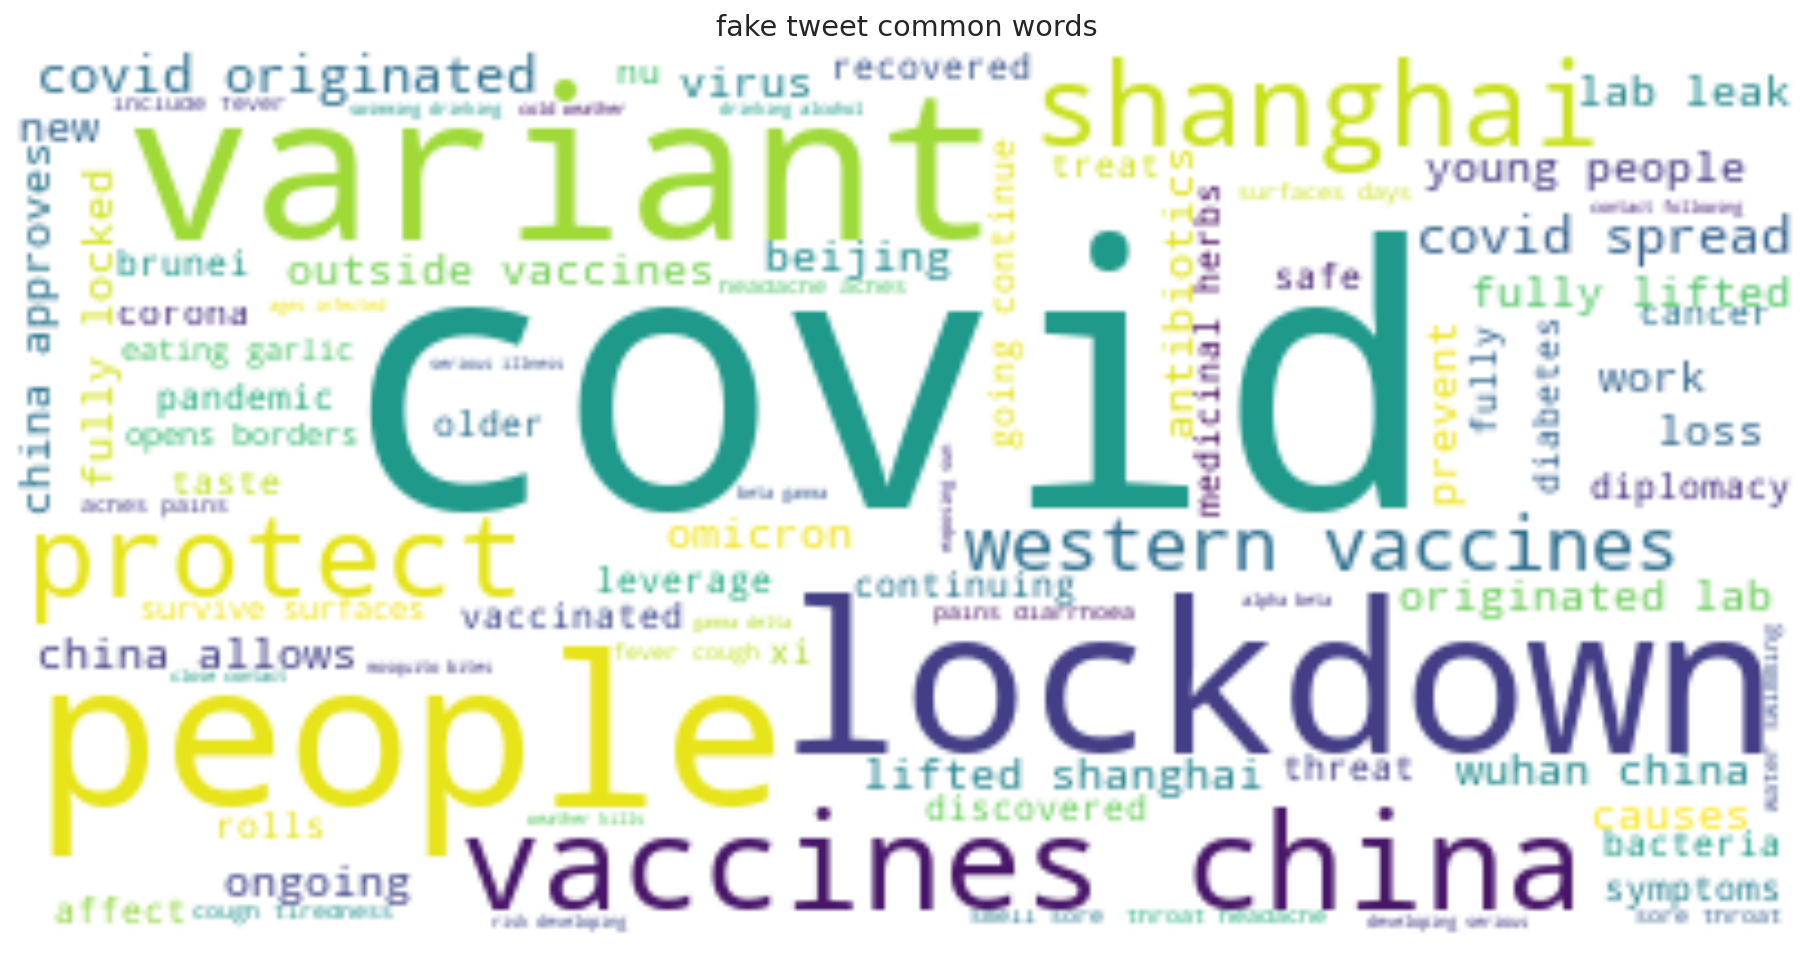

In [ ]:
show_word_cloud(fake_tweets_cloud, "fake tweet common words")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  tweet_df.legit.to_numpy().reshape(-1, 1)
)

In [ ]:
train_tweets, test_tweets, y_train, y_test =\
  train_test_split(
    tweet_df.text, 
    type_one_hot, 
    test_size=0.3,
    random_state=RANDOM_SEED
  )

In [ ]:
X_train = []
for r in tqdm(train_tweets):
  emb = use(r)
  tweet_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(tweet_emb)

X_train = np.array(X_train)

In [ ]:
X_test = []
for r in tqdm(test_tweets):
  emb = use(r)
  tweet_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(tweet_emb)

X_test = np.array(X_test)

In [ ]:
X_test

array([[ 0.02035102, -0.03342155, -0.03312605, ..., -0.06632043,
        -0.03191044, -0.03200909],
       [ 0.02577307, -0.01876946, -0.00345627, ..., -0.05055979,
         0.00057502,  0.05131244],
       [-0.03432982, -0.01962982, -0.01826807, ...,  0.0437022 ,
        -0.06829076, -0.01218164],
       ...,
       [ 0.03348521, -0.02124417, -0.01053692, ..., -0.0363985 ,
        -0.01765819,  0.02700486],
       [ 0.01094837, -0.00653584,  0.00638615, ..., -0.02068008,
        -0.02026328, -0.00692835],
       [ 0.00096651, -0.00705391, -0.0188624 , ..., -0.08454116,
        -0.00254908,  0.01442596]], dtype=float32)

In [ ]:
checkpoint_path = "training_checkpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
def create_model():
  model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1], )),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
  ])

  model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'])
    
  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelResult = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=16, 
    validation_split=0.3,
    verbose=1, 
    shuffle=True,
    # callbacks=[cp_callback]
)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.plot(modelResult.history['loss'], label='train loss')
plt.plot(modelResult.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

In [ ]:
plt.plot(modelResult.history['accuracy'], label='train accuracy')
plt.plot(modelResult.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
print(test_tweets.iloc[0])

people who are vaccinated can get covid


In [ ]:
print(test_tweets[:1])

33    people who are vaccinated can get covid
Name: text, dtype: object


In [ ]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Fake" if np.argmax(y_pred) == 0 else "Real"

1/1 [==============================] - 0s 91ms/step
[[0.5544687  0.44553128]]


'Fake'

In [ ]:
custom_text = []
user_entry = ['recovered people cannot get covid']

for r in tqdm(user_entry):
  emb = use(r)
  custom_emb = tf.reshape(emb, [-1]).numpy()
  custom_text.append(custom_emb)

custom_text = np.array(custom_text)
y_pred = model.predict(custom_text)
print("Real: ", y_pred[0][1]*100)
print("Fake: ", y_pred[0][0]*100)


100%|██████████| 1/1 [00:00<00:00, 11.71it/s]

1/1 [==============================] - 0s 25ms/step
Real:  36.3713264465332
Fake:  63.6286735534668


In [ ]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# latest

In [ ]:
model.save('legit.model')

INFO:tensorflow:Assets written to: legit.model/assets


INFO:tensorflow:Assets written to: legit.model/assets
